In [1]:
#imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.info

<bound method DataFrame.info of        gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              

In [3]:
# EDA
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nNull values per column:\n", df.isnull().sum())
print("\nTarget distribution:\n", df['diabetes'].value_counts(normalize=True))


Shape: (100000, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Null values per column:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes   

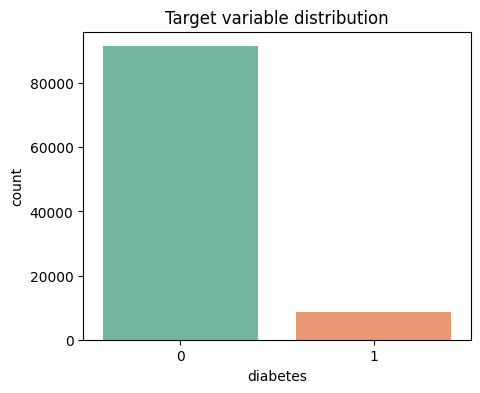

In [4]:
# ->Target Balance
plt.figure(figsize=(5,4))
sns.countplot(x='diabetes', data=df, palette="Set2")
plt.title("Target variable distribution")
plt.show()

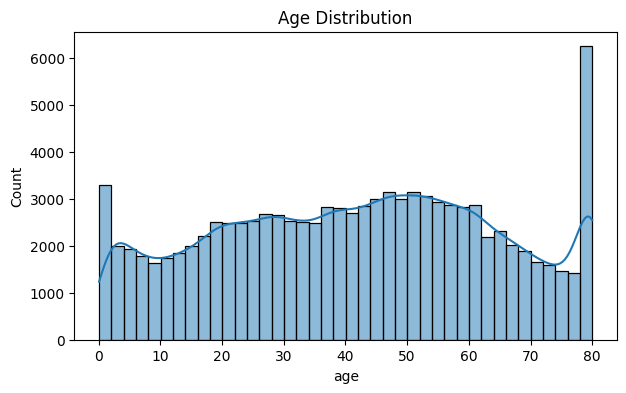

In [5]:
# ->Age distribution
plt.figure(figsize=(7,4))
sns.histplot(df['age'], bins=40, kde=True)
plt.title("Age Distribution")
plt.show()

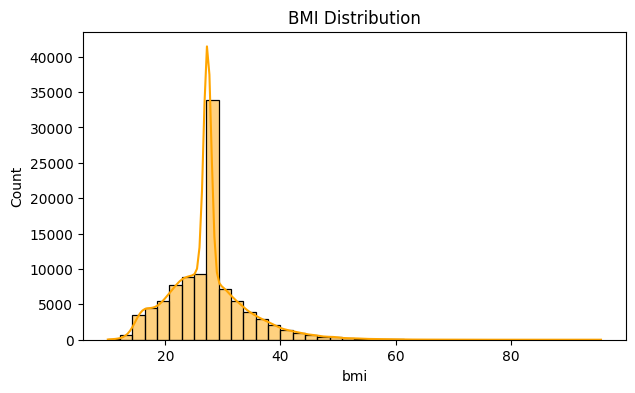

In [6]:
# ->BMI distribution
plt.figure(figsize=(7,4))
sns.histplot(df['bmi'], bins=40, kde=True, color="orange")
plt.title("BMI Distribution")
plt.show()

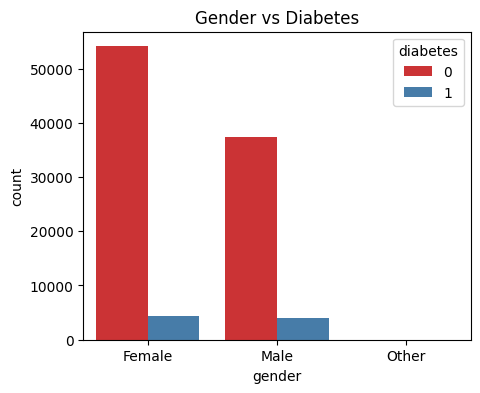

In [7]:
# ->Gender vs Diabetes
plt.figure(figsize=(5,4))
sns.countplot(x='gender', hue='diabetes', data=df, palette="Set1")
plt.title("Gender vs Diabetes")
plt.show()

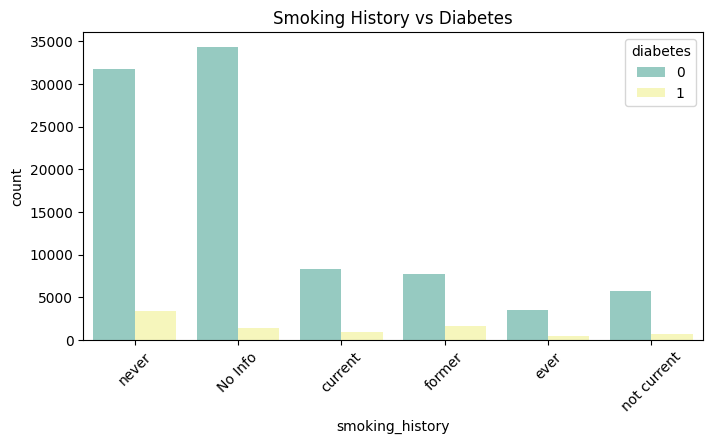

In [8]:
# ->Smoking history vs Diabetes
plt.figure(figsize=(8,4))
sns.countplot(x='smoking_history', hue='diabetes', data=df, palette="Set3")
plt.title("Smoking History vs Diabetes")
plt.xticks(rotation=45)
plt.show()

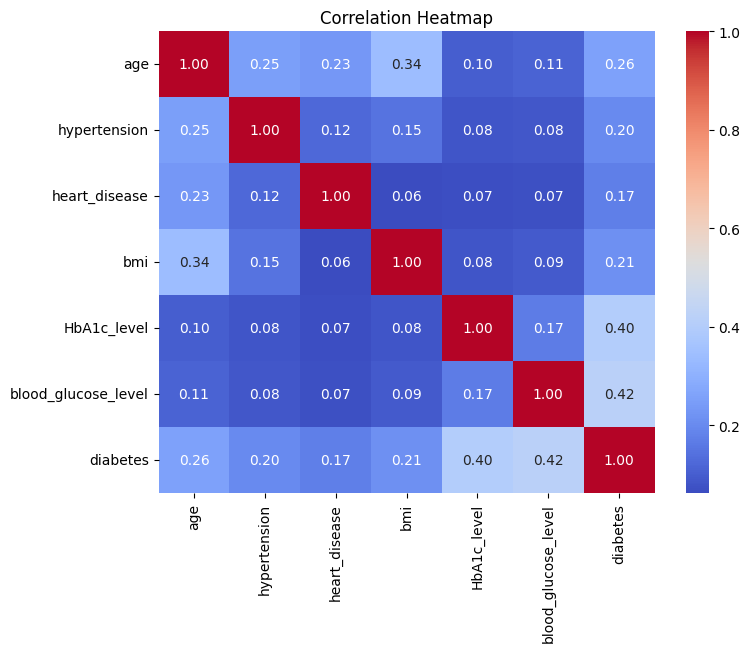

In [9]:
# ->Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [10]:
# Preprocessing
from sklearn.impute import SimpleImputer

numeric_features = ['age','bmi','HbA1c_level','blood_glucose_level']
binary_features = ['hypertension','heart_disease']
categorical_features = ['gender','smoking_history']

In [11]:
# Numeric: impute + scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [12]:
# Categorical: impute + one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='passthrough'  # keep hypertension, heart_disease
)

In [13]:
# Train/Test Split
X = df.drop(columns=['diabetes'])
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
# Models
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

models = {'Logistic Regression': pipe_lr, 'Random Forest': pipe_rf}


---- Logistic Regression ----
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     18300
           1       0.43      0.89      0.58      1700

    accuracy                           0.89     20000
   macro avg       0.71      0.89      0.76     20000
weighted avg       0.94      0.89      0.91     20000

ROC AUC: 0.9629446319511412


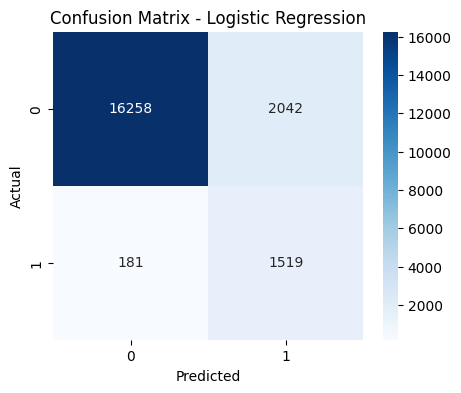


---- Random Forest ----
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.94      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.95      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

ROC AUC: 0.9663406621665059


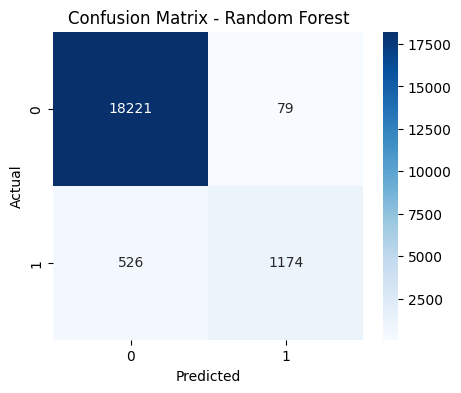

In [15]:
# Evaluation
for name, model in models.items():
    print(f"\n---- {name} ----")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()